In [ ]:
# Generic Libraries Used to work with Data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for Machine Learning Tasks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Data Preprocessing

Meta_DS = pd.read_csv('/content/drive/MyDrive/Datasets/meta.csv')
Apple_DS = pd.read_csv('/content/drive/MyDrive/Datasets/apple.csv')
Ebay_DS = pd.read_csv('/content/drive/MyDrive/Datasets/ebay.csv')
Google_DS = pd.read_csv('/content/drive/MyDrive/Datasets/google.csv')

new_Meta_DS = Meta_DS.copy()
new_Google_DS = Google_DS.copy()
new_Ebay_DS = Ebay_DS.copy()
new_Apple_DS = Apple_DS.copy()

new_Meta_DS.columns = 'Meta ' + Meta_DS.columns
new_Google_DS.columns = 'Google ' + Google_DS.columns
new_Ebay_DS.columns = 'Ebay ' + Ebay_DS.columns
new_Apple_DS.columns = 'Apple ' + Apple_DS.columns

merged_df = pd.concat([new_Meta_DS, new_Google_DS, new_Ebay_DS, new_Apple_DS], axis=1)
merged_df.drop(columns=['Meta Volume', 'Meta Close/Last', 'Meta High', 'Meta Low'], inplace=True)
merged_df.drop(columns=['Google Volume', 'Google Close/Last', 'Google High', 'Google Low', 'Google Date'], inplace=True)
merged_df.drop(columns=['Apple Volume', 'Apple Close/Last', 'Apple High', 'Apple Low', 'Apple  Date '], inplace=True)
merged_df.drop(columns=['Ebay Volume', 'Ebay Close/Last', 'Ebay High', 'Ebay Low', 'Ebay Date'], inplace=True)

merged_df.rename(columns={'Meta Date':'Date'}, inplace=True)

In [ ]:
# ADJUSTABLE
# Choose in X definition which to not predict
X = merged_df.drop(columns=['Date', 'Ebay Open', 'Meta Open', 'Google Open'])
#X = X.iloc[-50:]
y = merged_df['Apple Open']

# Normalize features using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Create sequences
sequence_length = 10
X_seq, y_seq = create_sequences(X_scaled, sequence_length)

In [ ]:
# Split data into training and testing sets
# Can't use train test split since we have to care
# about predicting future values, not just any values.
split_index = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

In [ ]:
# Define RNN model architecture
model = Sequential([
    LSTM(units=50, activation='relu', return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    LSTM(units=50, activation='relu'),
    Dense(units=1)
]) # Very Adjustable

model.compile(optimizer='adam', loss='mse') # Adjustable

history = model.fit(X_train, y_train, epochs=15, batch_size=1, validation_data=(X_test, y_test)) # Adjustable

model.summary()

Epoch 1/15
392/392 [==============================] - 6s 9ms/step - loss: 0.0454 - val_loss: 0.0127
Epoch 2/15
392/392 [==============================] - 4s 11ms/step - loss: 0.0384 - val_loss: 0.0293
Epoch 3/15
392/392 [==============================] - 4s 10ms/step - loss: 0.0381 - val_loss: 0.0144
Epoch 4/15
392/392 [==============================] - 3s 8ms/step - loss: 0.0375 - val_loss: 0.0133
Epoch 5/15
392/392 [==============================] - 3s 8ms/step - loss: 0.0373 - val_loss: 0.0128
Epoch 6/15
392/392 [==============================] - 3s 9ms/step - loss: 0.0371 - val_loss: 0.0079
Epoch 7/15
392/392 [==============================] - 5s 13ms/step - loss: 0.0369 - val_loss: 0.0113
Epoch 8/15
392/392 [==============================] - 3s 8ms/step - loss: 0.0369 - val_loss: 0.0171
Epoch 9/15
392/392 [==============================] - 3s 8ms/step - loss: 0.0368 - val_loss: 0.0143
Epoch 10/15
392/392 [==============================] - 3s 8ms/step - loss: 0.0365 - val_loss: 0.0

In [ ]:
future_steps = 10  # Adjustable
future_predictions = []

current_sequence = X_test[-1].reshape(1, sequence_length, X_test.shape[2])

for i in range(future_steps):

    # Predict next time step
    next_prediction = model.predict(current_sequence)

    # Append predicted value to list of future predictions
    # We only use [0][0] since we don't need the most detailed values
    future_predictions.append(next_prediction[0][0])

    # Create a new sequence for next time step
    next_sequence = np.zeros_like(current_sequence)
    next_sequence[:, :-1, :] = current_sequence[:, 1:, :]  # Shift existing sequence one step left
    next_sequence[:, -1, :] = next_prediction  # Replace last element with predicted value

    # Update current sequence for next iteration
    current_sequence = next_sequence

1/1 [==============================] - 0s 39ms/step


In [ ]:
future_predictions_array = np.array(future_predictions)

# Reshape future_predictions_reshaped to match shape of original input data
future_predictions_reshaped = future_predictions_array.reshape(-1, 1)

# Repeat predictions (adjusted when working with more than 1 feature)
future_predictions_reshaped = np.repeat(future_predictions_reshaped, 2, axis=1)

# Inverse transform predictions
future_predictions_scaled = scaler.inverse_transform(future_predictions_reshaped)

# Convert predictions back to original scale
new_future_predictions = future_predictions_scaled.flatten()

print(new_future_predictions)

[ 58.818836 178.596     54.68444  168.97978   50.977074 160.35681
  47.73177  152.80853   45.08943  146.66272   43.02638  141.86424
  41.48798  138.28609   40.419044 135.79984   39.70667  134.14291
  39.285866 133.16417 ]


0    186.06
1    186.54
2    184.35
3    183.92
4    182.09
5    181.99
6    182.15
7    184.22
8    187.15
Name: Open, dtype: float64
0      193.90
1      194.14
2      192.49
3      193.61
4      195.18
        ...  
496    172.89
497    172.70
498    179.61
499    182.63
500    177.83
Name: Apple Open, Length: 501, dtype: float64
[ 58.818836 178.596     54.68444  168.97978   50.977074 160.35681
  47.73177  152.80853   45.08943  146.66272   43.02638  141.86424
  41.48798  138.28609   40.419044 135.79984   39.70667  134.14291
  39.285866 133.16417 ]


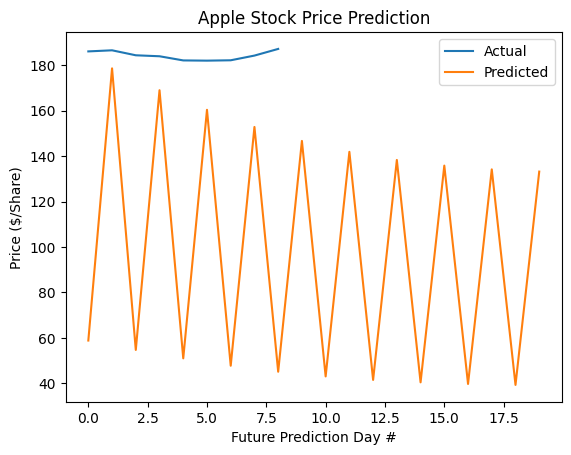

In [ ]:
Apple_2024 = pd.read_csv('/content/drive/MyDrive/Datasets/Apple-24.csv')
print(Apple_2024['Open'])
print(merged_df['Apple Open'])
print(new_future_predictions)
arr = []
for i in range(len(Apple_2024)):
  arr.append(i)

Apple_2024['Date'] = arr

X = np.array(Apple_2024['Date']).reshape(-1, 1)
y = Apple_2024['Open']

fig, ax = plt.subplots()
ax.plot(Apple_2024['Open'])
ax.plot(new_future_predictions)
ax.set_xlabel('Future Prediction Day #')
ax.set_ylabel('Price ($/Share)')
ax.legend(['Actual', 'Predicted'])
ax.set_title('Apple Stock Price Prediction')
plt.show()

#print(y)
#clf.score(X, y)